In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob

## Importing Data

In [2]:
##HRDPS import

files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2007m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

hr07_u = np.empty( (8*len(files), 266, 256)) 
hr07_v = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    for j in range(8):
        u_3 = np.array( dayX['u_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        v_3 = np.array( dayX['v_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        avg_u = u_3.mean(axis = 0) ##average of 3-hour time interval
        avg_v = v_3.mean(axis = 0)
        hr07_u[8*i + j, : , : ] = avg_u[0:266, 0:256] ##adding 3-hour average to new data array
        hr07_v[8*i + j, : , : ] = avg_v[0:266, 0:256]
del u_3
del v_3
del avg_u
del avg_v
del dayX

print(hr07_u.shape)

363
(2904, 266, 256)


In [3]:
##CANRCM 2007 import
p1 = '/home/arandhawa/canrcm_2007_uas.nc'
p2 = '/home/arandhawa/canrcm_2007_vas.nc'

d1 = xr.open_dataset(p1)
d2 = xr.open_dataset(p2)

can07_u = d1['uas'][16:,140:165,60:85]
can07_v = d2['vas'][16:,140:165,60:85]

print(can07_u.shape)

(2904, 25, 25)


## PCA Functions

In [4]:
##transforms and concatenates two data sets
def transform2(data1, data2):
    A_mat = transform(data1)
    B_mat = transform(data2)
    return np.concatenate((A_mat, B_mat), axis=0) 

In [5]:
def reverse2(matrix, orig_shape):
    split4 = int( matrix.shape[0]/2 )
    u_data = reverse(matrix[:split4,:], orig_shape) ##reconstructing u_winds from n PCs
    v_data = reverse(matrix[split4:,:], orig_shape) ##reconstructing v_winds from n PCs
    return (u_data, v_data)

In [6]:
##performs PCA analysis using sklearn.pca
def doPCA(comp, matrix):
    pca = PCA(n_components = comp) ##adjust the number of principle conponents to be calculated
    PCs = pca.fit_transform(matrix)
    eigvecs = pca.components_
    mean = pca.mean_
    return (PCs, eigvecs, mean)

In [7]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(-1, orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [8]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    del pcaG
    del PCsG

In [9]:
def get_mode(PCs, n, orig_shape): ##converts PCs (column vectors) to 2d conpoents for u and v wind
    split = int(PCs.shape[0]/2)
    mode_u = PCs[:split, n].reshape(orig_shape[1], orig_shape[2])
    mode_v = PCs[split:, n].reshape(orig_shape[1], orig_shape[2])
    return (mode_u, mode_v)

def graph_nPCs(PCs, eigvecs, n, orig_shape):
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    
    ax[0, 0].set_title("u-conponent")
    ax[0, 1].set_title("v-component")
    ax[0, 2].set_title("time-loadings")
    
    for i in range(n):
        mode_u, mode_v = get_mode(PCs, i, orig_shape)
        colors = ax[i, 0].pcolormesh(mode_u, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
        colors = ax[i, 1].pcolormesh(mode_v, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,1])
        ax[i, 2].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

## PCAs on Training Data

In [10]:
can07_mat = transform2(can07_u, can07_v)
can07_PCs, can07_eigs, can07_mean = doPCA(100, can07_mat)

hr07_mat = transform2(hr07_u, hr07_v)
hr07_PCs, hr07_eigs, hr07_mean = doPCA(100, hr07_mat)

In [11]:
can07_eigs.shape

(100, 2904)

In [12]:
can07_mean.reshape(1, -1).shape

(1, 2904)

In [13]:
comb = np.concatenate((can07_mean.reshape(1, -1), can07_eigs), axis = 0)
comb.shape

(101, 2904)

In [14]:
del hr07_u
del hr07_v
del can07_u
del can07_v

## Multiple Linear Regression

In [15]:
def fit_modes(vectors, mean1, num_vec, data_hr, mean2, result_size, type = 'LS'):  
    
    X = np.concatenate((mean1.reshape(1, -1), vectors[0:num_vec,:]), axis = 0).T
    data = np.concatenate((mean2.reshape(1, -1) , data_hr), axis = 0)
    result = np.zeros((result_size + 1, X.shape[0]))
    scores = np.zeros(result_size + 1)
    
    if type == 'LS':
        for i in range(result_size + 1):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
            
    elif type == 'MAE':
        for i in range(result_size + 1):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            result[i] = reg.predict(X)
            scores[i] = reg.score(X, y)
    
    return (result, scores)

In [16]:
def getCoefs(vectors, mean1, num_vec, data_hr, mean2, num_modes, type = 'LS'):  
    
    X = np.concatenate((mean1.reshape(1, -1), vectors[0:num_vec,:]), axis = 0).T
    data = np.append(mean2.reshape(1, -1), data_hr, axis = 0)
    coefs = np.zeros((num_modes + 1, X.shape[1]))
    intercept = np.zeros(num_modes + 1)
    
    if type == 'LS':
        for i in range(num_modes + 1):
            y = data[i,:]
            reg = LinearRegression().fit(X, y)
            coefs[i] = reg.coef_[0:num_vec + 1]
            intercept[i] =  reg.intercept_
    elif type == 'MAE':
        for i in range(num_modes + 1):
            y = data[i,:]
            reg = QuantileRegressor(quantile = 0.5, alpha = 0, solver = 'highs').fit(X, y)
            coefs[i] = reg.coef_[0:num_vec + 1]
            intercept[i] =  reg.intercept_
    
    return (coefs, intercept)


In [17]:
def getEnergyCoefs(eigs, old_mean, old_eigs):
    coefs = np.empty(eigs.shape[0])
    coefs[0] = np.sqrt( (old_mean**2).mean()/(eigs[0]**2).mean())
    coefs[1:] = np.sqrt( (old_eigs[0:eigs.shape[0] - 1]**2).mean(axis = 1)/(eigs[1:]**2).mean(axis = 1))
    return coefs

In [55]:
coefs, _ = getCoefs(can07_eigs, can07_mean, 50, hr07_eigs, hr07_mean, 50, type = 'LS')

(51, 2904)


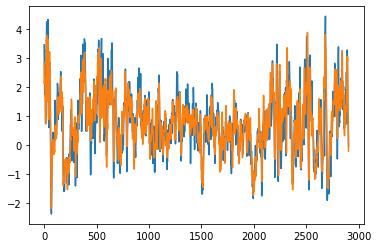

In [23]:
result, _ = fit_modes(can07_eigs, can07_mean, 50, hr07_eigs, hr07_mean, 50, type = 'LS')
plt.plot(hr07_mean)
plt.plot(result[0])
print(result.shape)

(51,)


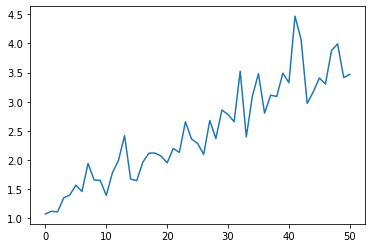

In [60]:
new_eigs, _ = fit_modes(can07_eigs, can07_mean, 50, hr07_eigs, hr07_mean, 50, type = 'LS')
energyCoefs = getEnergyCoefs(new_eigs, hr07_mean, hr07_eigs)
del new_eigs
plt.plot(energyCoefs)
print(energyCoefs.shape)

## PCA on 2008 data

In [18]:
##supposed to be 2008 canrcm data
p1 = '/home/arandhawa/canrcm_2008_uas.nc'
p2 = '/home/arandhawa/canrcm_2008_vas.nc'

d1 = xr.open_dataset(p1)
d2 = xr.open_dataset(p2)

In [19]:
##duplicating feb 28 twice to account for leap year (feb 29th is missing)
can08_u = np.concatenate((d1['uas'][:472,140:165,60:85], d1['uas'][464:472,140:165,60:85], d1['uas'][472:,140:165,60:85] ))
can08_v = np.concatenate((d2['vas'][:472,140:165,60:85], d2['vas'][464:472,140:165,60:85], d2['vas'][472:,140:165,60:85]))

In [ ]:
##not duplicating feb 28 twice
##can08_u = d1['uas'][16:,140:165,60:85]
##can08_v = d2['vas'][16:,140:165,60:85]

In [20]:
can08_mat = transform2(can08_u, can08_v)

##conducting PCA analysis on combined data matrix
PCs, eigvecs, mean_2008 = doPCA(30, can08_mat)

In [ ]:
## graph_nPCs(PCs, eigvecs, 3, hr08_u.shape)

## Predictions

In [21]:
def project(u, v):  ##scalar projection of u onto v - with extra 1/norm factor (for math reasons)
    v_norm = np.sqrt(np.sum(v**2))    
    return np.dot(u, v)/v_norm**2

def projectData(data_mat, new_PCs, n):
    time = data_mat.shape[1]
    proj = np.empty((n, time))

    for j in range(n):
        for i in range(time):
            proj[j, i] = project(data_mat[:,i], new_PCs[:,j])
            
    return proj

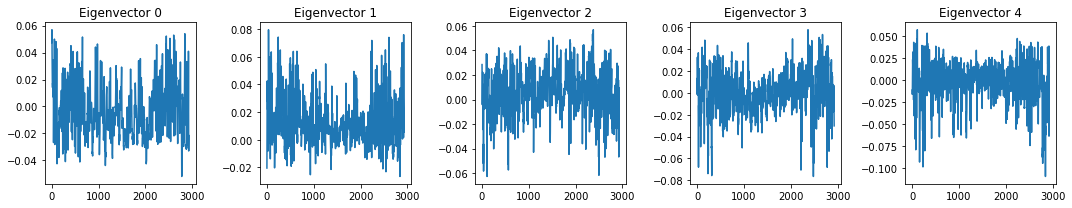

In [53]:
proj = projectData(can08_mat, can07_PCs, 50)

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].set_title("Eigenvector {}".format(i))
    ax[i].plot(proj[i])
plt.tight_layout()

In [57]:
proj.shape

(52, 2928)

In [61]:
proj = projectData(can08_mat, can07_PCs, 50)
proj = np.concatenate((mean_2008.reshape(1, -1), proj), axis = 0)

pred_eigs = np.matmul(coefs[0], proj) + coefs[1].reshape(-1, 1)  ##multiple linear regression output
pred_eigs = pred_eigs*energyCoefs.reshape(-1, 1) ##energy balancing
recon = np.matmul(hr07_PCs[:,0:50], pred_eigs[1:51]) + pred_eigs[0]
u_data_rec, v_data_rec = reverse2(recon, (-1, 266, 256))


In [63]:
del proj
del pred_eigs
del recon

## Overall Function

In [22]:
def reconstruct(downscale_mat, mean, can_PCs, can_eigs, can_mean, hr_PCs, hr_eigs, hr_mean, n, r, method = 'LS', EB = True):

    coefs = getCoefs(can_eigs, can_mean, n, hr_eigs, hr_mean, r, type = method)
    proj = np.concatenate((mean.reshape(1, -1), projectData(downscale_mat, can_PCs, n)), axis = 0)
    pred_eigs = np.matmul(coefs[0], proj) + coefs[1].reshape(-1, 1)  ##multiple linear regression output
    if (EB == True):
        energyCoefs = getEnergyCoefs( fit_modes(can_eigs, can_mean, n, hr_eigs, hr_mean, r, type = method)[0] , hr_mean, hr07_eigs)
        energyCoefs = energyCoefs.reshape(-1, 1)
        pred_eigs = pred_eigs*energyCoefs ##energy balancing
    
    recon = np.matmul(hr_PCs[:,0:r], pred_eigs[1:r+1]) + pred_eigs[0]
    u_data_rec, v_data_rec = reverse2(recon, (-1, 266, 256))
    
    return (u_data_rec, v_data_rec)

## Analysis

In [23]:
##HRDPS import

files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2008m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

hr08_u = np.empty( (8*len(files), 266, 256)) 
hr08_v = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    for j in range(8):
        u_3 = np.array( dayX['u_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        v_3 = np.array( dayX['v_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        avg_u = u_3.mean(axis = 0) ##average of 3-hour time interval
        avg_v = v_3.mean(axis = 0)
        hr08_u[8*i + j, : , : ] = avg_u[0:266, 0:256] ##adding 3-hour average to new data array
        hr08_v[8*i + j, : , : ] = avg_v[0:266, 0:256]
del u_3
del v_3
del avg_u
del avg_v
del dayX

366


In [24]:
HB_u = hr08_u[:,142,139]
SS_u = hr08_u[:,174,107]
SH_u = hr08_u[:,129,149]

HB_v = hr08_v[:,142,139]
SS_v = hr08_v[:,174,107]
SH_v = hr08_v[:,129,149]

del hr08_u
del hr08_v

print(HB_u.shape)

(2928,)


In [31]:
u_data_rec, v_data_rec = reconstruct(can08_mat, mean_2008, can07_PCs, can07_eigs, can07_mean, hr07_PCs, hr07_eigs, hr07_mean, 75, 75, method = 'LS', EB = False)

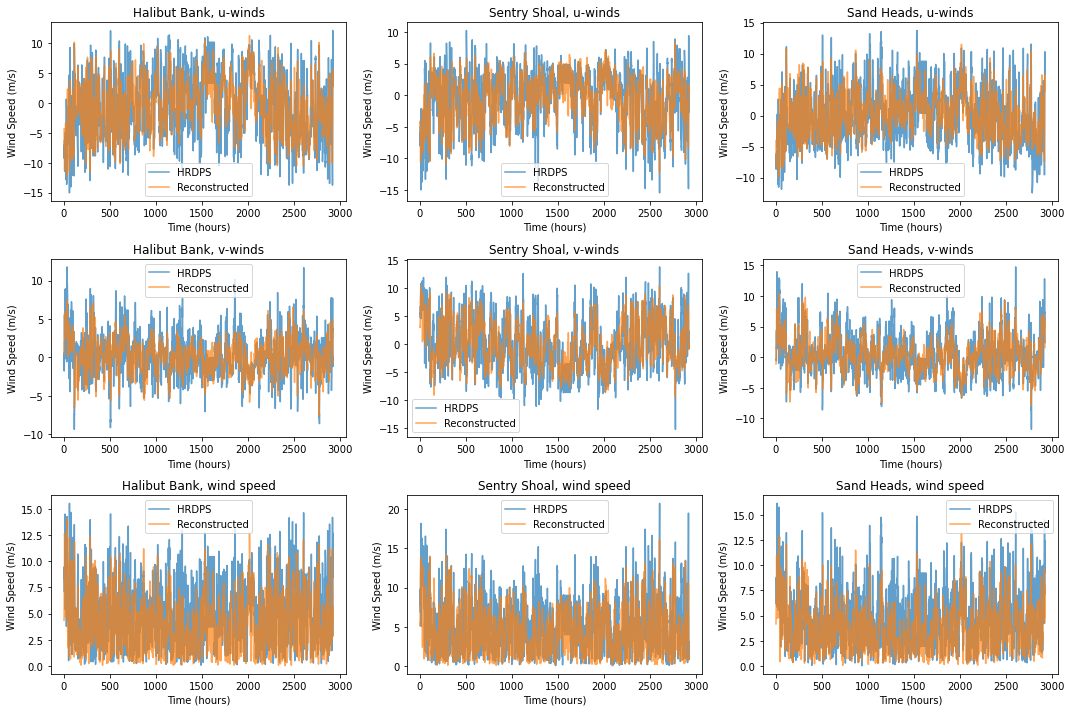

In [32]:
## Plotting data at three locations.

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
alpha_val = 0.7

ax[0, 0].plot(HB_u, label = "HRDPS", alpha = alpha_val)
ax[0, 0].plot(u_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[0, 0].set_title("Halibut Bank, u-winds")
ax[0, 0].set_xlabel("Time (hours)")
ax[0, 0].set_ylabel("Wind Speed (m/s)")
ax[0, 0].legend()

ax[0, 1].plot(SS_u, label = "HRDPS", alpha = alpha_val)
ax[0, 1].plot(u_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[0, 1].set_title("Sentry Shoal, u-winds")
ax[0, 1].set_xlabel("Time (hours)")
ax[0, 1].set_ylabel("Wind Speed (m/s)")
ax[0, 1].legend()

ax[0, 2].plot(SH_u, label = "HRDPS", alpha = alpha_val)
ax[0, 2].plot(u_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[0, 2].set_title("Sand Heads, u-winds")
ax[0, 2].set_xlabel("Time (hours)")
ax[0, 2].set_ylabel("Wind Speed (m/s)")
ax[0, 2].legend()

ax[1, 0].plot(HB_v, label = "HRDPS", alpha = alpha_val)
ax[1, 0].plot(v_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[1, 0].set_title("Halibut Bank, v-winds")
ax[1, 0].set_xlabel("Time (hours)")
ax[1, 0].set_ylabel("Wind Speed (m/s)")
ax[1, 0].legend()

ax[1, 1].plot(SS_v, label = "HRDPS", alpha = alpha_val)
ax[1, 1].plot(v_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[1, 1].set_title("Sentry Shoal, v-winds")
ax[1, 1].set_xlabel("Time (hours)")
ax[1, 1].set_ylabel("Wind Speed (m/s)")
ax[1, 1].legend()

ax[1, 2].plot(SH_v, label = "HRDPS", alpha = alpha_val)
ax[1, 2].plot(v_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[1, 2].set_title("Sand Heads, v-winds")
ax[1, 2].set_xlabel("Time (hours)")
ax[1, 2].set_ylabel("Wind Speed (m/s)")
ax[1, 2].legend()

ax[2,0].plot(np.sqrt(HB_u**2 + HB_v**2), label = "HRDPS", alpha = alpha_val)
ax[2,0].plot(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,0].set_xlabel("Time (hours)")
ax[2,0].set_title("Halibut Bank, wind speed")
ax[2,0].set_ylabel("Wind Speed (m/s)")
ax[2,0].legend()

ax[2,1].plot(np.sqrt(SS_u**2 + SS_v**2), label = "HRDPS", alpha = alpha_val)
ax[2,1].plot(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,1].set_xlabel("Time (hours)")
ax[2,1].set_title("Sentry Shoal, wind speed")
ax[2,1].set_ylabel("Wind Speed (m/s)")
ax[2,1].legend()

ax[2,2].plot(np.sqrt(SH_u**2 + SH_v**2) , label = "HRDPS", alpha = alpha_val)
ax[2,2].plot(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , label = "Reconstructed", alpha = alpha_val)
ax[2,2].set_xlabel("Time (hours)")
ax[2,2].set_title("Sand Heads, wind speed")
ax[2,2].set_ylabel("Wind Speed (m/s)")
ax[2,2].legend()

plt.tight_layout()

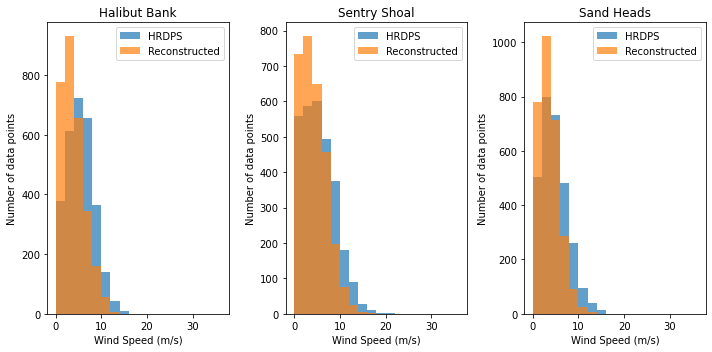

In [33]:
nums = np.arange(0, 37, 2)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].set_title("Halibut Bank")
ax[0].hist(np.sqrt(HB_u**2 + HB_v**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[0].hist(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[0].set_xlabel("Wind Speed (m/s)")
ax[0].set_ylabel("Number of data points")
ax[0].legend()

ax[1].set_title("Sentry Shoal")
ax[1].hist(np.sqrt(SS_u**2 + SS_v**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[1].hist(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[1].set_xlabel("Wind Speed (m/s)")
ax[1].set_ylabel("Number of data points")
ax[1].legend()

ax[2].set_title("Sand Heads")
ax[2].hist(np.sqrt(SH_u**2 + SH_v**2) , bins = nums,  label = "HRDPS", alpha = 0.7)
ax[2].hist(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2].set_xlabel("Wind Speed (m/s)")
ax[2].set_ylabel("Number of data points")
ax[2].legend()

plt.tight_layout()

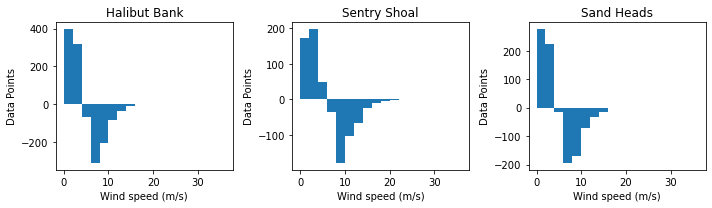

In [34]:
a1 = np.histogram(np.sqrt(HB_u**2 + HB_v**2), bins = nums)
b1 = np.histogram(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums)

a2 = np.histogram(np.sqrt(SS_u**2 + SS_v**2), bins = nums)
b2 = np.histogram(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums)

a3 = np.histogram(np.sqrt(SH_u**2 + SH_v**2), bins = nums)
b3 = np.histogram(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums)

# calc middle of bin and width of bin
axes = [(a1[1][x]+a1[1][x+1])/2 for x in range(len(a1[1])-1)] 
w = a1[1][1]
##plot differences
fig, ax = plt.subplots(1, 3, figsize = (10, 3))

ax[0].bar(axes, b1[0] - a1[0], width=w, label="Reconstruct - HRDPS 2008")
ax[0].set_title("Halibut Bank")
ax[1].bar(axes, b2[0] - a2[0], width=w, label="Reconstruct - HRDPS 2008")
ax[1].set_title("Sentry Shoal")
ax[2].bar(axes, b3[0] - a3[0], width=w, label="Reconstruct - HRDPS 2008")
ax[2].set_title("Sand Heads")

for i in range(3):
    ax[i].set_xlabel("Wind speed (m/s)")
    ax[i].set_ylabel("Data Points")
plt.tight_layout()

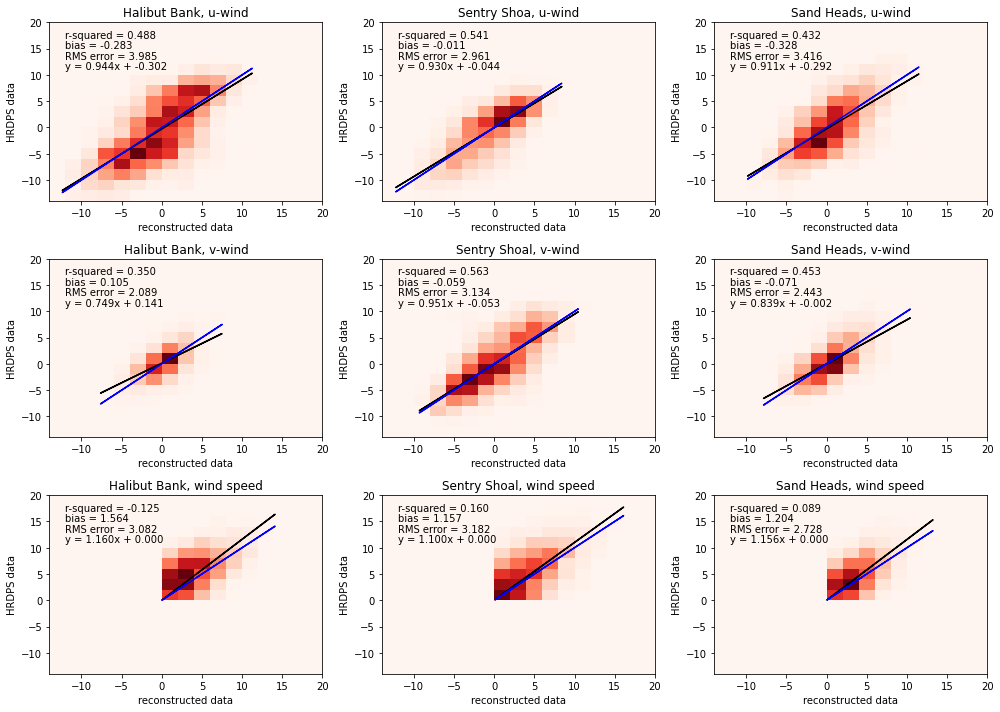

In [35]:
metrics = np.zeros((3, 3, 3))

def helper(x, y, ax, i, j):
    
    if i == 2:
        myBool = False
    else:
        myBool = True
    
    reg = LinearRegression(fit_intercept = myBool).fit(x.reshape(-1, 1), y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_pred = a*x + b
    
    bias = np.mean( y - x )
    r_squared = reg.score(x.reshape(-1, 1), y)
    rmse = np.sqrt( mean_squared_error(y, y_pred) )
    
    global metrics
    metrics[i, j, 0] = r_squared
    metrics[i, j, 1] = bias
    metrics[i, j, 2] = rmse
    
    im = ax[i,j].hist2d(x, y, bins = (17, 17), range = [[-14, 20], [-14, 20]], cmap=plt.cm.Reds)
    ax[i,j].plot(x, a*x+b, color = 'black')
    ax[i,j].plot(x, x, color = 'blue')
    ax[i,j].annotate("r-squared = {:.3f}".format(r_squared), (-12, 17))
    ax[i,j].annotate("bias = {:.3f}".format(bias), (-12, 15))
    ax[i,j].annotate("RMS error = {:.3f}".format(rmse), (-12, 13))
    ax[i,j].annotate("y = {:.3f}x + {:.3f}".format(a, b), (-12, 11))
    ax[i,j].set_ylabel("HRDPS data")
    ax[i,j].set_xlabel("reconstructed data")
    ax[i,j].set_ylim(-14, 20)
    ax[i,j].set_xlim(-14, 20)
    ## plt.colorbar(im,ax=ax[i,j]) 
    ##https://stackoverflow.com/questions/23876588/matplotlib-colorbar-in-each-subplot

    return (a, b)


a = np.empty((3, 3))
b = np.empty((3, 3))

fig, ax = plt.subplots(3, 3, figsize = (14, 10))
##Habibut bank
y = HB_u
x = u_data_rec[:, 142, 139]
ax[0, 0].set_title("Halibut Bank, u-wind")
a[0,0], b[0,0] = helper(x, y, ax, 0, 0)

y = HB_v
x = v_data_rec[:, 142, 139]
ax[1, 0].set_title("Halibut Bank, v-wind")
a[1,0], b[1,0] = helper(x, y, ax, 1, 0)

y = np.sqrt(HB_u**2 + HB_v**2)
x = np.sqrt(u_data_rec[:, 142, 139]**2 + v_data_rec[:, 142, 139]**2)
ax[2, 0].set_title("Halibut Bank, wind speed")
a[2,0], b[2,0] = helper(x, y, ax, 2, 0)

##Sentry Shoal
y = SS_u
x = u_data_rec[:,174, 107]
ax[0, 1].set_title("Sentry Shoa, u-wind")
a[0,1], b[0,1] = helper(x, y, ax, 0, 1)

y = SS_v
x = v_data_rec[:,174, 107]
ax[1, 1].set_title("Sentry Shoal, v-wind")
a[1,1], b[1,1] = helper(x, y, ax, 1, 1)

y = np.sqrt(SS_u**2 + SS_v**2)
x = np.sqrt(u_data_rec[:,174, 107]**2 + v_data_rec[:,174, 107]**2)
ax[2, 1].set_title("Sentry Shoal, wind speed")
a[2,1], b[2,1] = helper(x, y, ax, 2, 1)

##Sand Heads
y = SH_u
x = u_data_rec[:,129,149]
ax[0, 2].set_title("Sand Heads, u-wind")
a[0,2], b[0,2] = helper(x, y, ax, 0, 2)

y = SH_v
x = v_data_rec[:,129,149]
ax[1, 2].set_title("Sand Heads, v-wind")
a[1,2], b[1,2] = helper(x, y, ax, 1, 2)

y = np.sqrt(SH_u**2 + SH_v**2)
x = np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2)
ax[2, 2].set_title("Sand Heads, wind speed")
a[2,2], b[2,2] = helper(x, y, ax, 2, 2)

plt.tight_layout()

In [36]:
##metrics used to rate fit

ex = np.zeros(b1[0].shape)
rmse = np.sqrt( mean_squared_error(b1[0] - a1[0], ex) )
rmse += np.sqrt( mean_squared_error(b2[0] - a2[0], ex) )
rmse += np.sqrt( mean_squared_error(b3[0] - a3[0], ex) )
rmse_hist = rmse/3
print("histogram rmse:", rmse_hist)
print("   R^2,         bias,       RMSE")
avg = np.mean(np.mean(metrics[0:2], axis = 1), axis = 0)
print(avg)

histogram rmse: 112.8140919168706
   R^2,         bias,       RMSE
[ 0.47102855 -0.10781108  3.00449849]
